In [1]:
from Binaries import *

Trigger = HardwareClassifier()

def make_plots(dataset, trigger):

    plt.rcParams["figure.figsize"] = [40, 20]

    warnings.simplefilter("ignore", RuntimeWarning)
    colormap = cmap.get_cmap("plasma")

    c = lambda x, i : x.split("_")[i]
    root_path = "/cr/tempdata01/filip/QGSJET-II/LTP/BINNED/"
    checksum = lambda x : sum([10*float(c(x,0)), 10*float(c(x,1)), float(c(x,3))/10, float(c(x,4)[:-4])/10])
    ldf_files = np.array(os.listdir(root_path))[np.argsort([checksum(file) for file in os.listdir(root_path )])]
    ldf_files = [root_path + ldf_file for ldf_file in ldf_files]
    err = lambda x, o : np.clip(1/(x + o)**2 * np.sqrt( x**3 + o**3 - 2 * np.sqrt((x * o)**3) ), 1e-5, 1)


    TP, FP, TN, FN = Trigger.load_and_print_performance(dataset)

    bar_kwargs = \
    {
        "fmt" : "o",
        "elinewidth" : 0.5,
        "capsize" : 3
    }

    e_labels = [r"$16$", r"$16.5$", r"$17$", r"$17.5$", r"$18$", r"$18.5$", r"$19$", r"$19.5$"]            
    annotate = lambda e : e_labels[e] + r" $\leq$ log($E$ / eV) $<$ " + e_labels[e + 1]

    energy_bins = [10**16, 10**16.5, 10**17, 10**17.5, 10**18, 10**18.5, 10**19, 10**19.5]      # uniform in log(E)
    theta_bins =  [0.0000, 33.5600, 44.4200, 51.3200, 56.2500, 65.3700]                         # pseudo-uniform in sec(θ)

    miss_sorted = [[ [] for t in range(len(theta_bins) - 1) ] for e in range(len(energy_bins) - 1)]
    hits_sorted = [[ [] for t in range(len(theta_bins) - 1) ] for e in range(len(energy_bins) - 1)]

    # Sort predictions into bins of theta and energy
    for source, target in zip([TP, FN], [hits_sorted, miss_sorted]):

        spd, energy, theta = source[:, 0], source[:, 1], source[:, 2]
        energy_sorted = np.digitize(energy, energy_bins)
        theta_sorted = np.digitize(theta, theta_bins)

        for i, j, shower_plane_distance in zip(energy_sorted, theta_sorted, spd):
            target[i - 1][j - 1].append(shower_plane_distance)

    fig, axes = plt.subplots(3, 3, sharex = False, sharey = True)
    axes[-1][-1].axis("off"), axes[-1][-2].axis("off")


    # Calculate efficiencies given sorted performances
    # axis 1 = sorted by primary particles' energy
    for i_e, (hits, misses) in enumerate(zip(hits_sorted, miss_sorted)):

        ax = axes[i_e // 3][i_e % 3]

        if i_e >= 4: 
            ax.set_xlabel("Shower plane distance / m")
            ax.set_xticks([1e3, 2e3, 3e3, 4e3, 5e3])
        else:
            ax.set_xticks([])
        if i_e % 3 == 0: ax.set_ylabel("Trigger efficiency")

        ax.errorbar([],[], yerr = [], c = "k", **bar_kwargs, label = "Bayesian folding")
        ax.errorbar([],[], c = "k", mfc = "w", fmt = "-o", label = r"$\overline{\textrm{Off}}$\hspace{.05em}\protect\raisebox{.4ex}{$\protect\underline{\textrm{line}}$ counting", zorder = 0, markersize = 15)
        ax.legend(loc = "upper right", title = annotate(i_e))

        # axis 2 = sorted by zenith angle
        for i_t, (hits, misses) in enumerate(zip(hits, misses)):

            c = colormap(i_t / (len(theta_bins) - 1))

            spd, all_hits, miss, th1, th2, tot, totd, mops = np.loadtxt(ldf_files[i_e * 5 + i_t], unpack = True)


            if trigger == "all":
                y = all_hits / (all_hits + miss)
                yerr = err(all_hits, miss)
            if trigger == "th1":
                y = th1 / (miss + th1)
                yerr = err(th1, miss)
            elif trigger == "th2":
                y = th2 / (miss + th2)
                yerr = err(th2, miss)
            elif trigger == "tot":
                y = tot / (miss + tot)
                yerr = err(tot, miss)
            elif trigger == "totd":
                y = totd / (totd + miss)
                yerr = err(totd, miss)
            elif trigger == "mops":
                y = mops / (mops + miss)
                yerr = err(mops, miss)

            ax.errorbar(spd - 50, y, mfc = "w", color = c, fmt = "-o")

            LDF, (LDF_efficiency, LDF_prob_50, LDF_scale) = get_fit_function("/cr/tempdata01/filip/QGSJET-II/LDF/", i_e, i_t)
            LDF = lambda x : lateral_distribution_function(x, LDF_efficiency, LDF_prob_50, 1/LDF_scale)

            all_data = hits + misses
            n_data_in_bins = int(50 * np.sqrt(i_e + 1))

            # have at least 7 bins or bins with >50 samples
            while True:
                n_bins = len(all_data) // n_data_in_bins
                probabilities = np.linspace(0, 1, n_bins)
                binning = mquantiles(all_data, prob = probabilities)
                bin_center = 0.5 * (binning[1:] + binning[:-1])
                n_all, _ = np.histogram(all_data, bins = binning)

                if len(n_all) <= 7: 
                    n_data_in_bins -= 10
                    if n_data_in_bins == 50: break
                else: break

            x, _ = np.histogram(hits, bins = binning)
            o, _ = np.histogram(misses, bins = binning)
            efficiency = x / (x + o) * LDF(bin_center)
            efficiency_err = 1/n_all**2 * np.sqrt( x**3 + o**3 - 2 * np.sqrt((x * o)**3) )          # lack LDF error part here !!
            efficiency_err[efficiency_err == 0] = 1e-3                                              # such that residuals are finite

            upper = np.clip(efficiency + efficiency_err, 0, 1)
            lower = np.clip(efficiency - efficiency_err, 0, 1)

            markers, caps, bars = ax.errorbar(bin_center, efficiency, yerr = [efficiency - lower, upper - efficiency], color = c, alpha = 0.7, zorder = 1, **bar_kwargs)
            [bar.set_alpha(0.1) for bar in bars]
            [cap.set_alpha(0.4) for cap in caps]

    # norm = BoundaryNorm(theta_bins, colormap.N)
    # ax2 = fig.add_axes([0.92, 0.1, 0.01, 0.8])
    # cbar = ColorbarBase(ax2, cmap=colormap, norm=norm, label = r"sec$(\theta)$ - 1")
    # cbar.set_ticks(theta_bins)
    # cbar.set_ticklabels(["0.0", "0.2", "0.4", "0.6", "0.8", "1.4"])

    plt.subplots_adjust(hspace = 0.04, wspace = 0)

    norm = BoundaryNorm([bin for bin in theta_bins], colormap.N)
    ax2 = fig.add_axes([0.92, 0.1, 0.01, 0.8])
    cbar = ColorbarBase(ax2, cmap=colormap, norm=norm, label = r"sec$(\theta)$ - 1")
    cbar.set_ticks([int(bin) for bin in theta_bins])
    cbar.set_ticklabels(["0.0", "0.2", "0.4", "0.6", "0.8", "1.4"])

    warnings.simplefilter("default", RuntimeWarning)

/tmp/ipykernel_1856865/4216960500.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cmap.get_cmap("plasma")



Classifier                                    Dataset                                  TP      FP      TN      FN
HardwareClassifier                            final_totd_only                      100138       0       0  145914 -> ACC =  40.70%


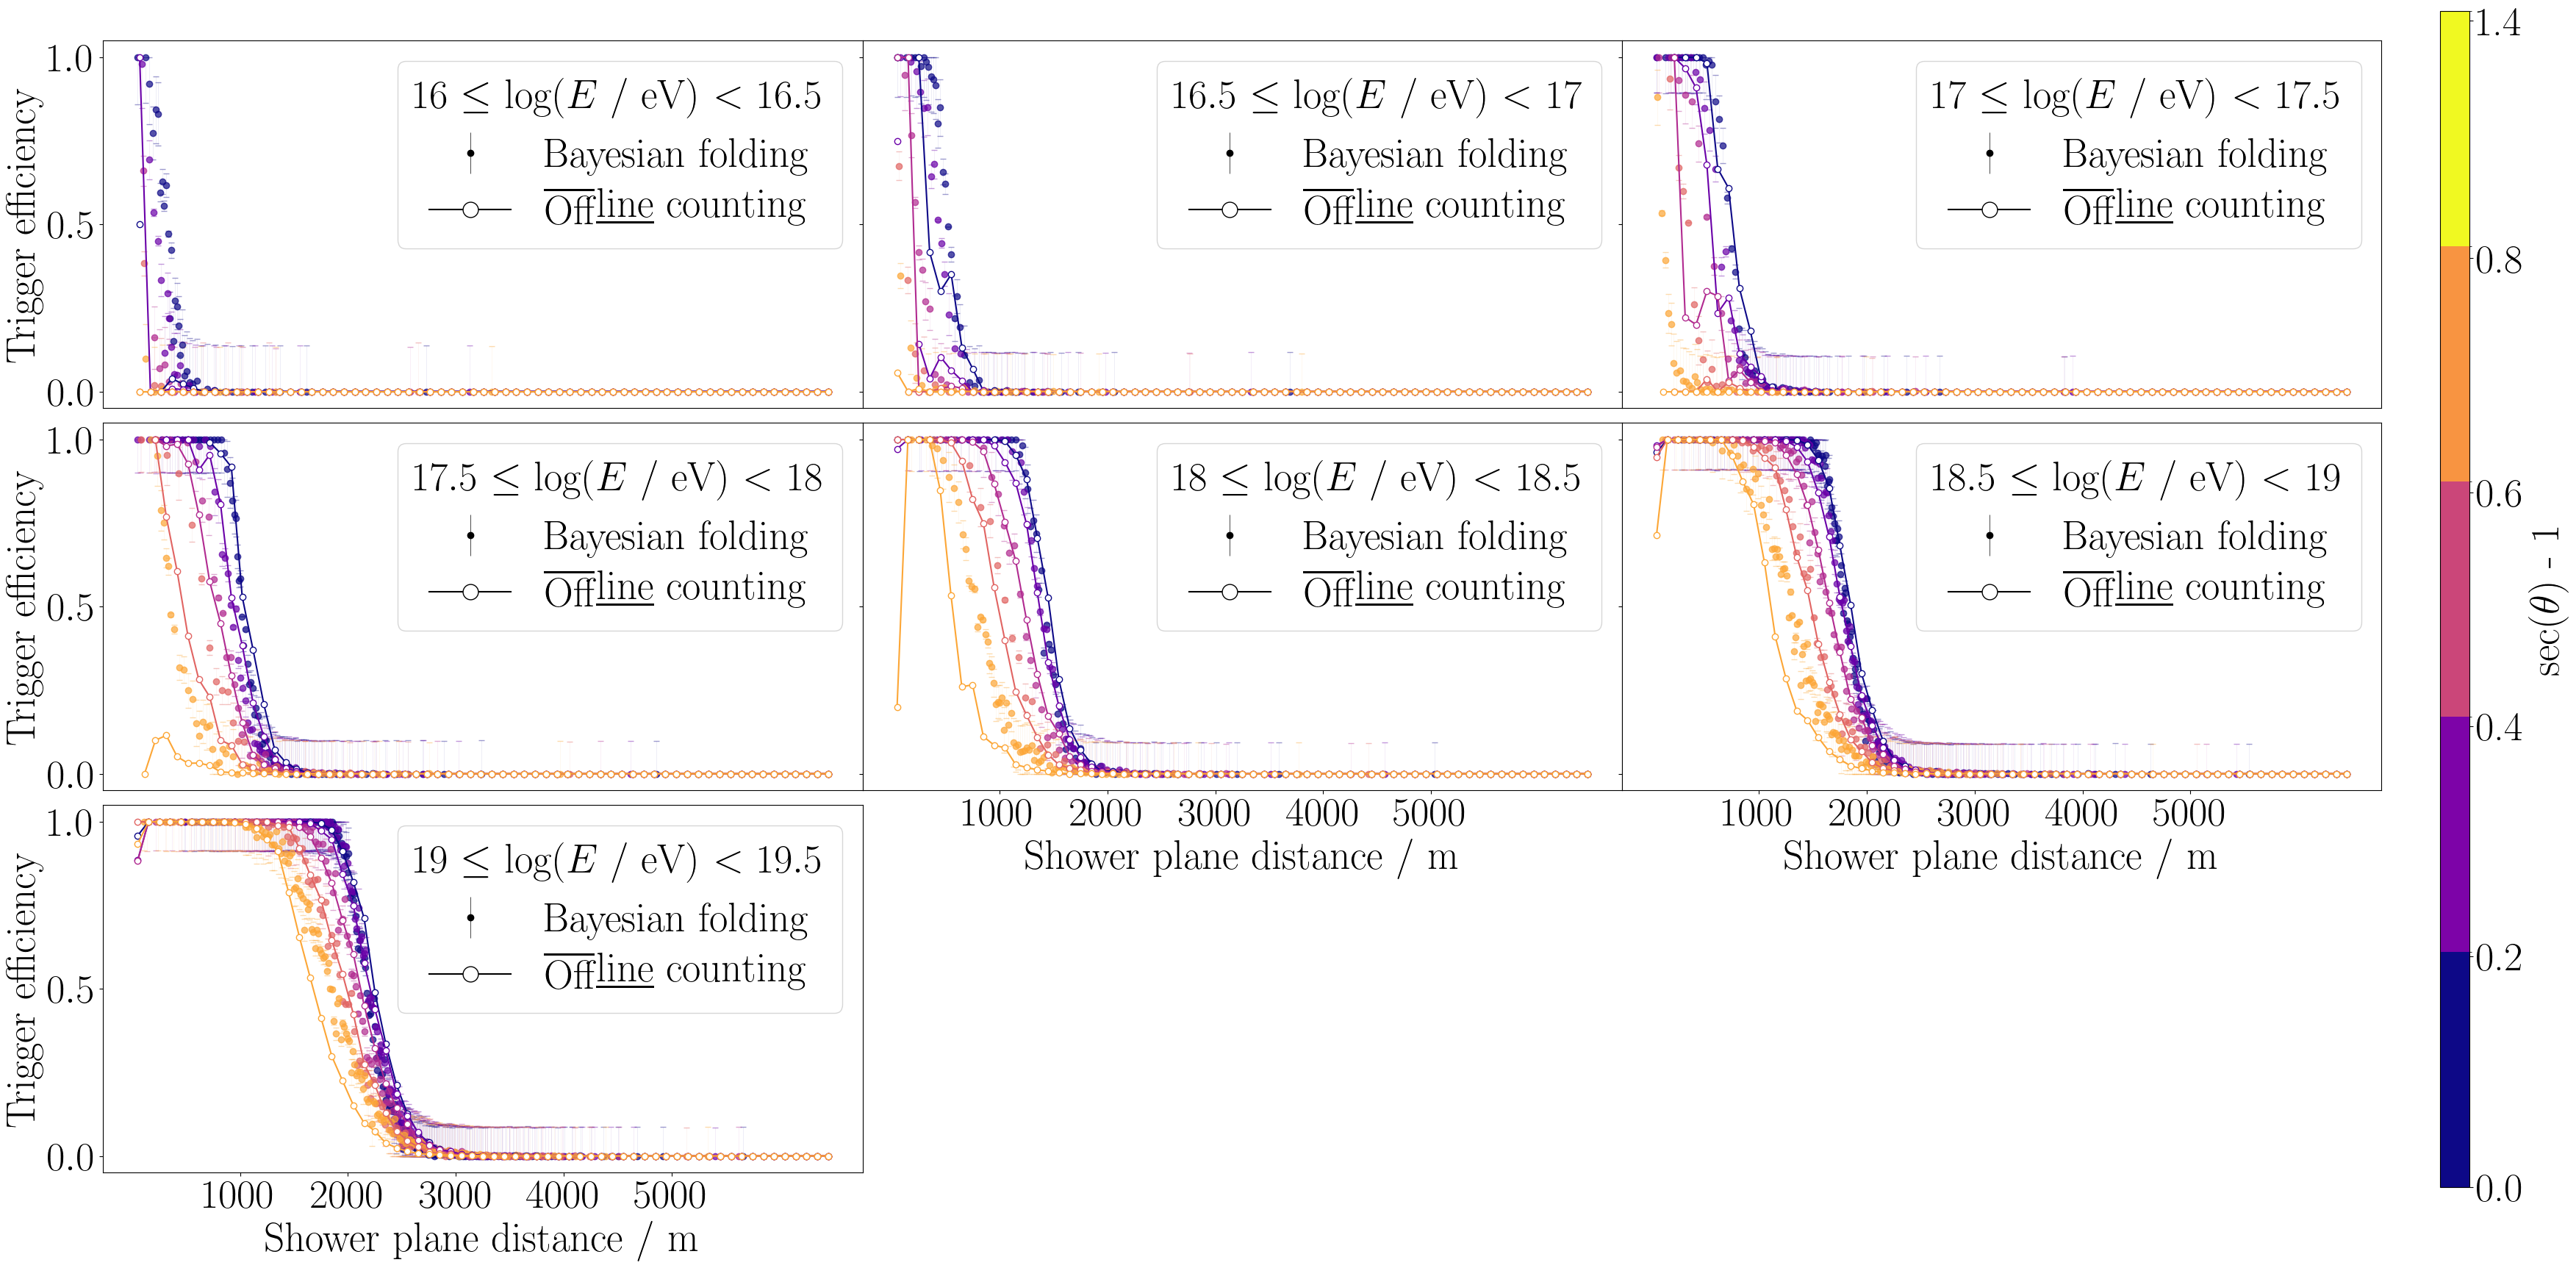

In [2]:
make_plots("final_totd_only", "mops")

HardwareClassifier                            final_all_triggers                    89144       0       0  156908 -> ACC =  36.23%


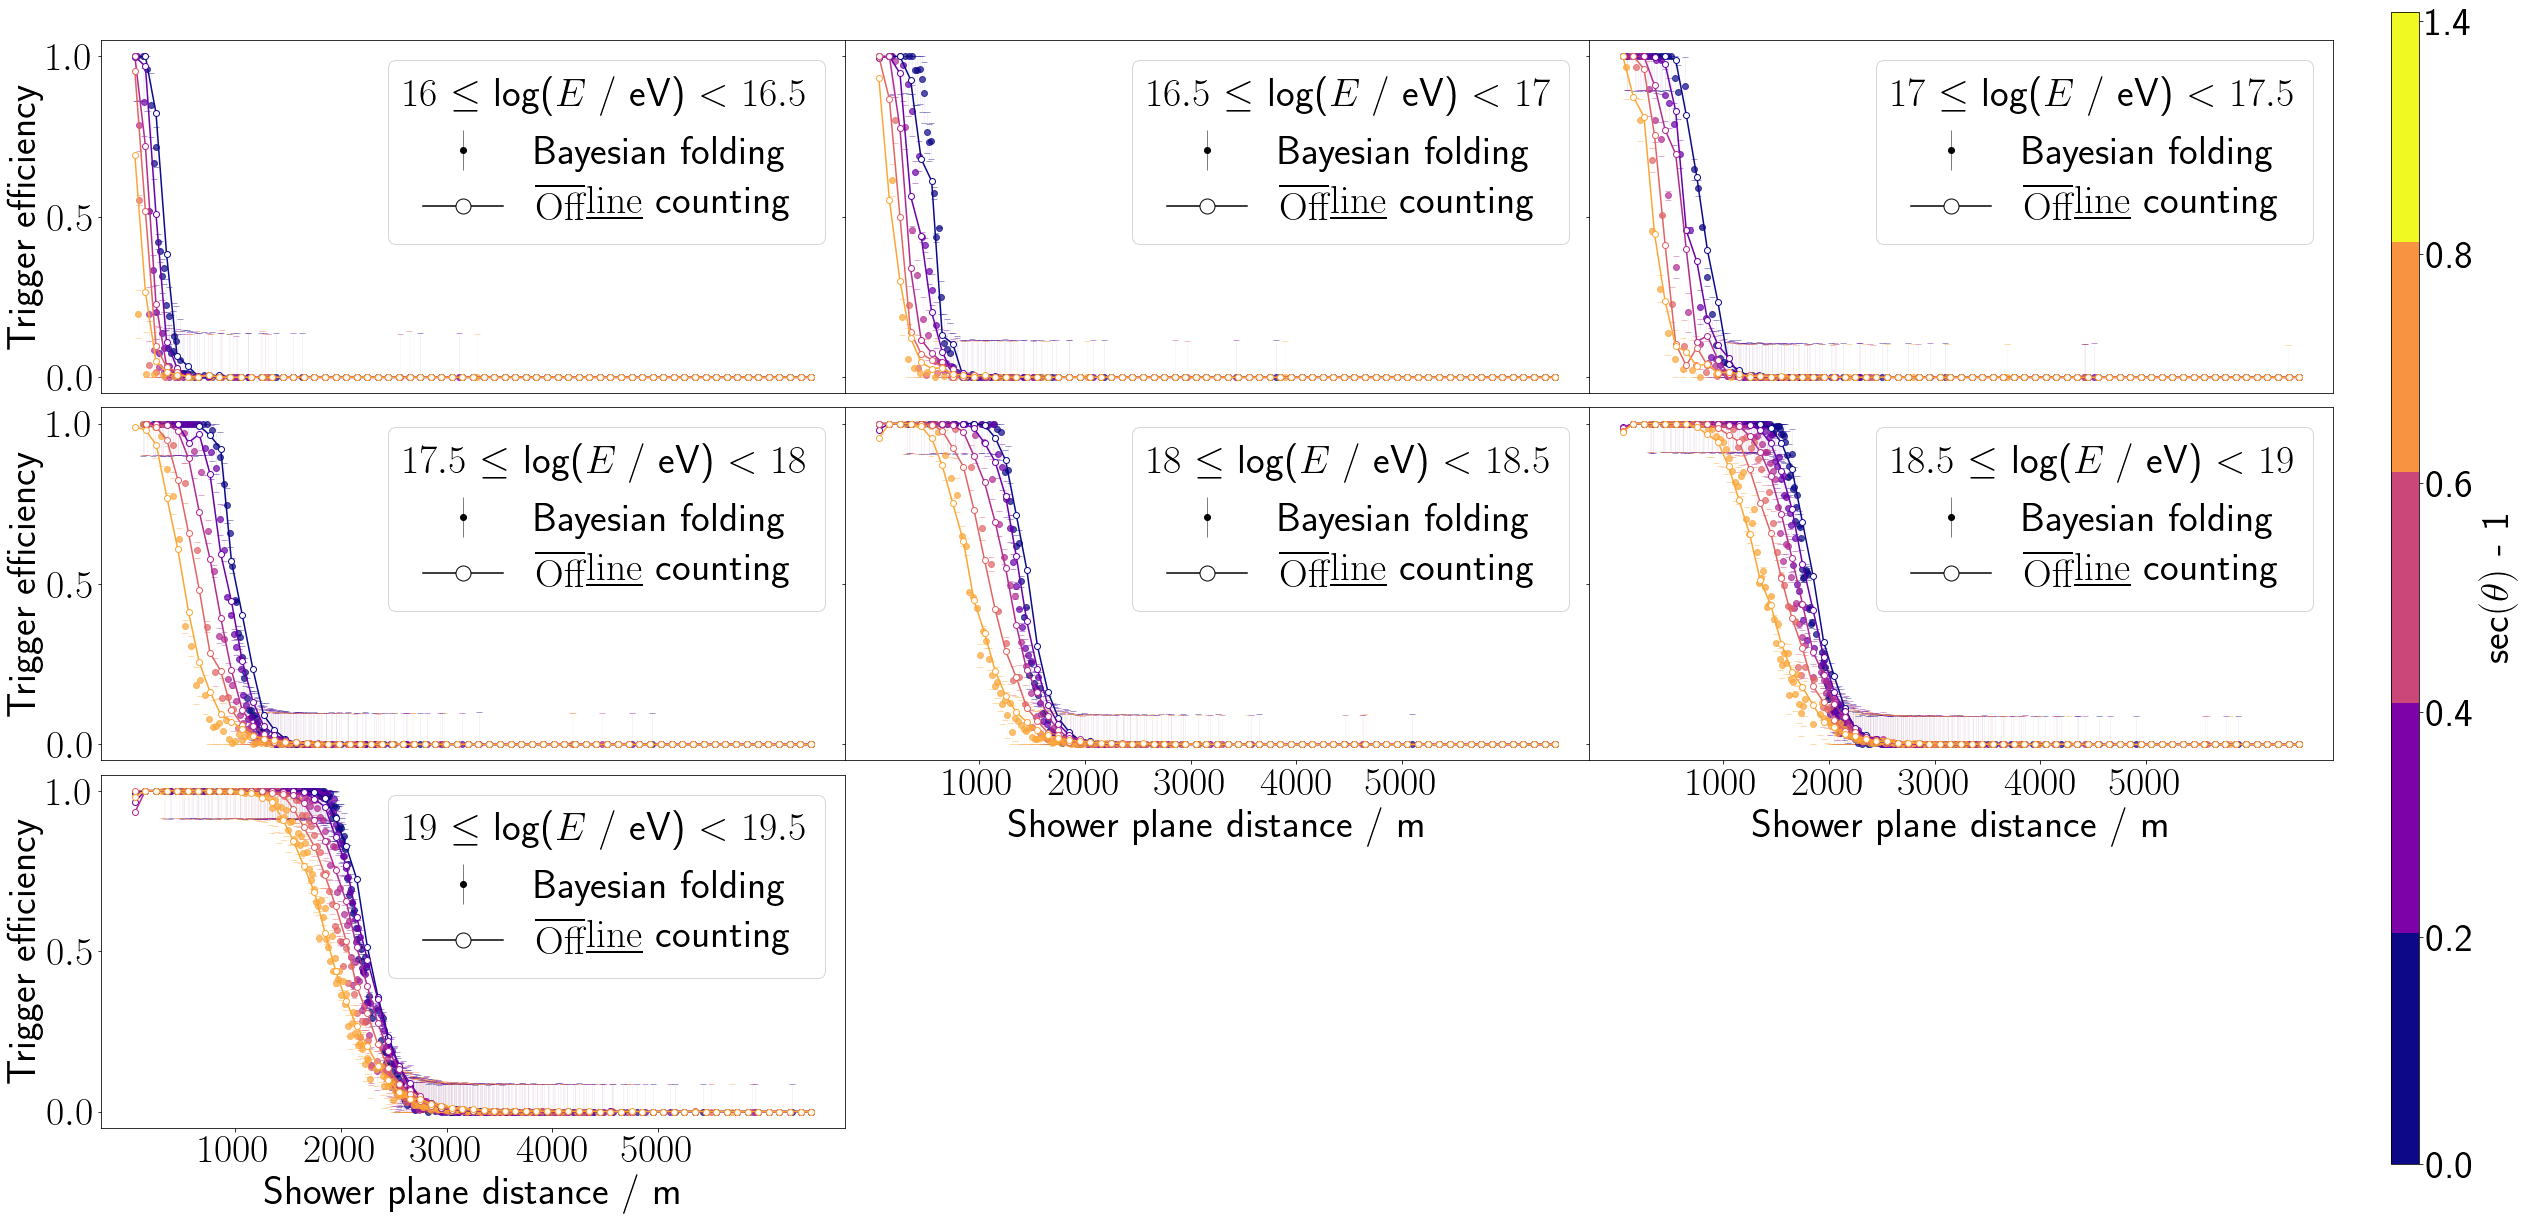

In [18]:
make_plots("final_all_triggers", "all")